In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
Fs = 1000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/Fs)  # Time vector from 0 to 1 second

freqs = np.arange(10, 110, 10)  # [10, 20, ..., 100]


## Generate  the composite signal

In [3]:
signal = np.zeros_like(t)
for f in freqs:
    signal += np.sin(2 * np.pi * f * t)

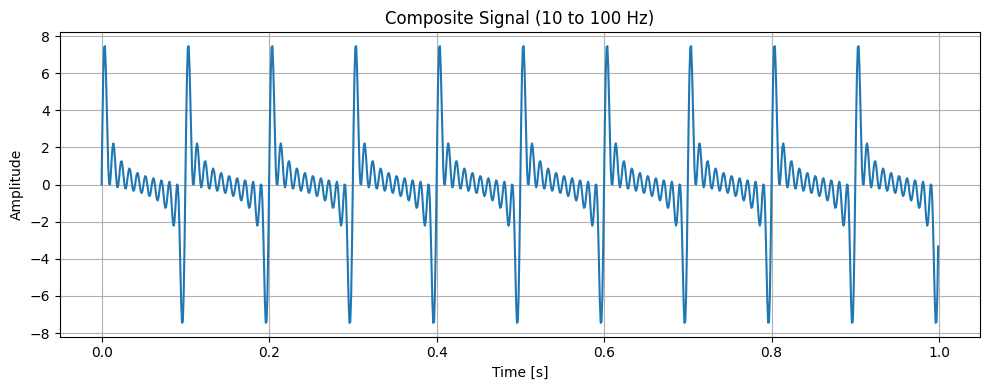

In [4]:
plt.figure(figsize=(10,4))
plt.plot(t, signal)
plt.title('Composite Signal (10 to 100 Hz)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

## Add Noise

In [5]:
amplitude = np.max(np.abs(signal))
noise_std = 0.3 * amplitude
noise = np.random.normal(0, noise_std, size=signal.shape)
noisy_signal = signal + noise

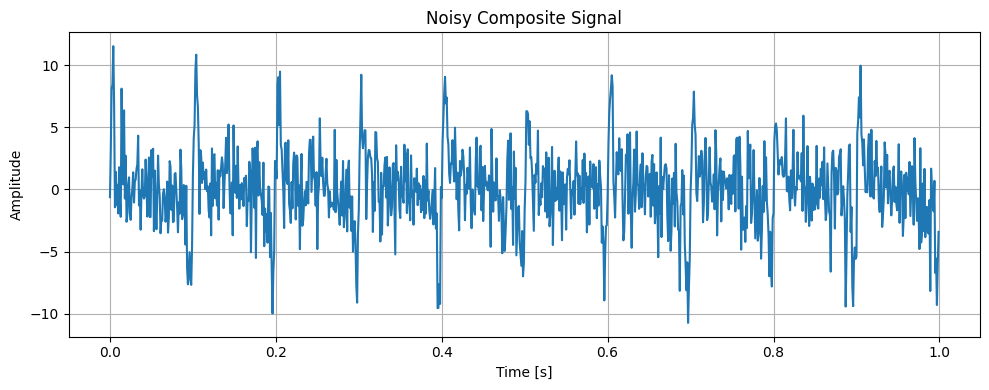

In [6]:
plt.figure(figsize=(10,4))
plt.plot(t, noisy_signal)
plt.title('Noisy Composite Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

## Compute the FFT of the noisy signal

In [7]:
fft_freqs = np.fft.fftfreq(len(t), d=1/Fs)
fft_signal = np.fft.fft(noisy_signal)

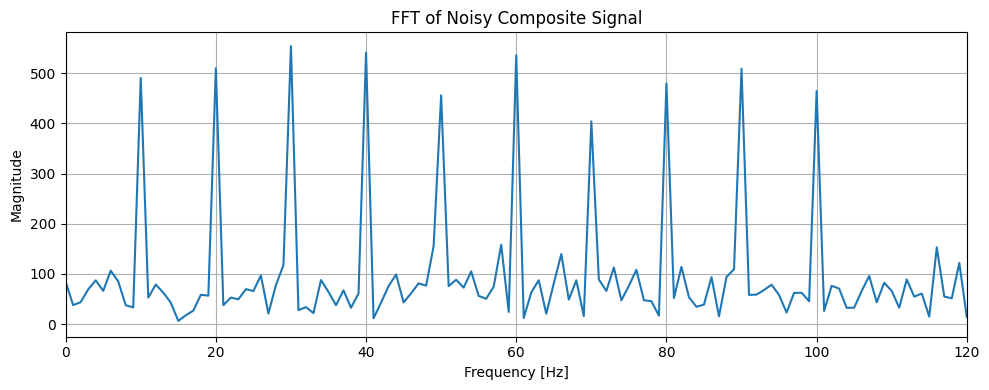

In [8]:
plt.figure(figsize=(10,4))
plt.plot(fft_freqs[:len(fft_freqs)//2], np.abs(fft_signal)[:len(fft_signal)//2])
plt.title('FFT of Noisy Composite Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 120)
plt.tight_layout()
plt.show()

## Reconstruct signals using IFFT

In [9]:
reconstructed_signal = np.fft.ifft(fft_signal)
reconstructed_signal = np.real(reconstructed_signal)

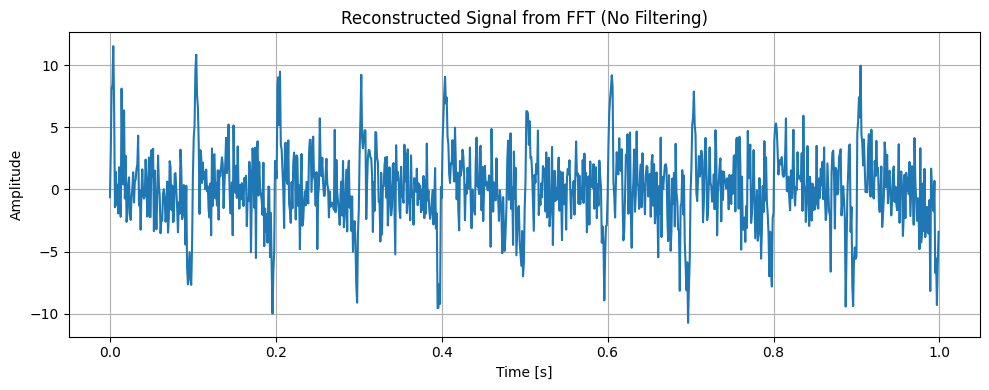

In [10]:
plt.figure(figsize=(10,4))
plt.plot(t, reconstructed_signal)
plt.title('Reconstructed Signal from FFT (No Filtering)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


## Filtering the FFTs

In [11]:
bandwidth = 2  # Hz bandwidth around the target frequencies
mask = np.zeros_like(fft_signal, dtype=bool)

for f in freqs:
    mask |= (np.abs(fft_freqs - f) <= bandwidth) | (np.abs(fft_freqs + f) <= bandwidth)

filtered_fft_signal = fft_signal * mask

filtered_reconstructed_signal = np.fft.ifft(filtered_fft_signal)
filtered_reconstructed_signal = np.real(filtered_reconstructed_signal)

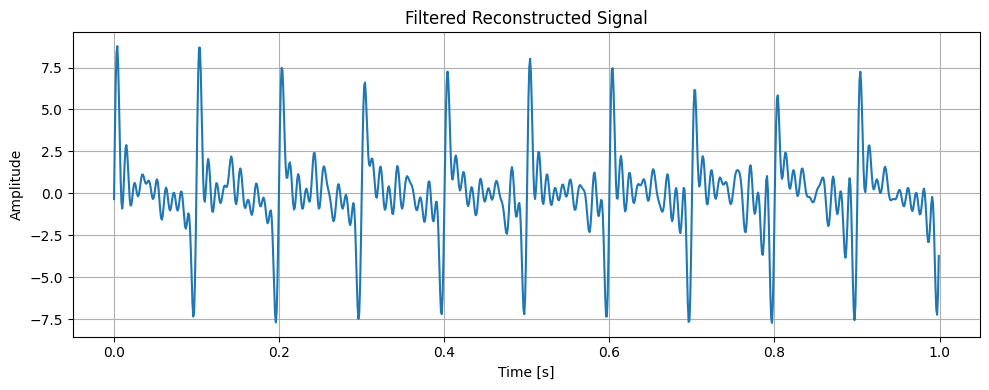

In [12]:
plt.figure(figsize=(10,4))
plt.plot(t, filtered_reconstructed_signal)
plt.title('Filtered Reconstructed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

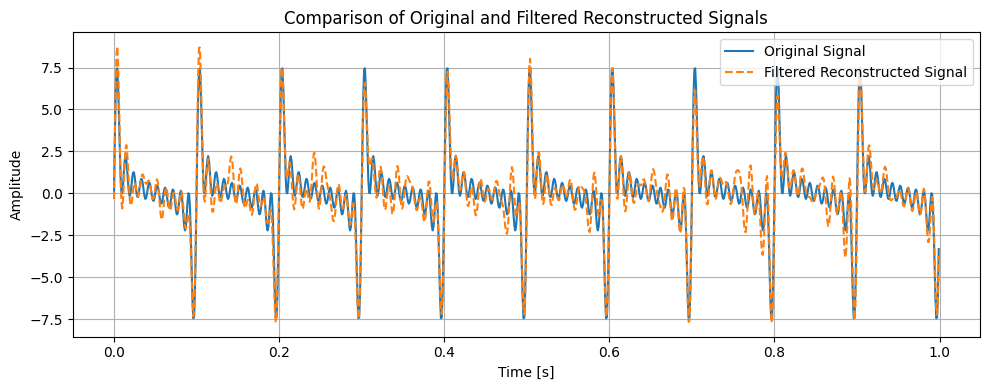

In [13]:
plt.figure(figsize=(10,4))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, filtered_reconstructed_signal, label='Filtered Reconstructed Signal', linestyle='--')
plt.title('Comparison of Original and Filtered Reconstructed Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Multiband Equalizer

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from scipy.signal import butter, filtfilt


def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def filter_(signal, f0, f1, sample_rate, order=2):
    b, a = butter_bandpass(f0, f1, sample_rate, order=order)
    return filtfilt(b, a, signal)

max_frequency = max(freqs)

# Create sliders for the parameters
fc1_slider = widgets.IntSlider(min=10, max=max_frequency, step=10, value=50, description='fc1')
fc2_slider = widgets.IntSlider(min=10, max=max_frequency, step=10, value=50, description='fc2')
fc3_slider = widgets.IntSlider(min=10, max=max_frequency, step=10, value=70, description='fc3')
wb_slider = widgets.FloatSlider(min=10, max=max_frequency/2, step=10, value=30, description='wb')
gain1_slider = widgets.IntSlider(min=-10, max=10, step=1, value=0, description='gain1')
gain2_slider = widgets.IntSlider(min=-10, max=10, step=1, value=0, description='gain2')
gain3_slider = widgets.IntSlider(min=-10, max=10, step=1, value=0, description='gain3')

# Output widget for the plot
output = widgets.Output()

def update_plot(change=None):
    with output:
        output.clear_output(wait=True)  # Clear the previous plot

        # Get current slider values
        fc1 = fc1_slider.value
        fc2 = fc2_slider.value
        fc3 = fc3_slider.value
        wb = wb_slider.value
        g1 = gain1_slider.value
        g2 = gain2_slider.value
        g3 = gain3_slider.value

        sample_rate = Fs

        # Helper to ensure valid band limits
        def valid_band(fcenter):
            f0 = max(fcenter - wb, 0.1)
            f1 = min(fcenter + wb, sample_rate/2 - 0.1)
            return f0, f1

        f0_1, f1_1 = valid_band(fc1)
        f0_2, f1_2 = valid_band(fc2)
        f0_3, f1_3 = valid_band(fc3)

        band1 = filter_(signal, f0_1, f1_1, sample_rate)
        band2 = filter_(signal, f0_2, f1_2, sample_rate)
        band3 = filter_(signal, f0_3, f1_3, sample_rate)

        # Apply individual gains
        band1_adj = band1 * np.power(10, g1 / 20)
        band2_adj = band2 * np.power(10, g2 / 20)
        band3_adj = band3 * np.power(10, g3 / 20)

        # Reconstruct the equalized signal
        original_bands_sum = band1 + band2 + band3
        signal_equalized = (signal - original_bands_sum) + band1_adj + band2_adj + band3_adj

        # Plot the equalized signal
        plt.figure(figsize=(10,4))
        plt.plot(t, signal_equalized, label='Equalized Signal')
        plt.title('Equalized Signal with Independent Gains per Band')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.ylim(-12, 12)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Call update_plot whenever any slider changes
for w in [fc1_slider, fc2_slider, fc3_slider, wb_slider, gain1_slider, gain2_slider, gain3_slider]:
    w.observe(update_plot, 'value')

# Create a layout with sliders on the left and the plot on the right
ui = widgets.HBox([
    widgets.VBox([fc1_slider, fc2_slider, fc3_slider, wb_slider, gain1_slider, gain2_slider, gain3_slider]),
    output
])

display(ui)
update_plot()  # Update plot once at the beginning
